In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import *
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer , KNNImputer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import *
from sklearn.pipeline import *
from sklearn.tree import *
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import *

2023-01-04 23:07:32.424422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 23:07:32.605675: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-04 23:07:33.164870: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:
2023-01-04 23:07:33.165129: W tensorflow/compiler/xla/stream_executor/platfor

利用df.info()查看資料集各個column的種類 + null的人有幾列 , 已決定接下來要怎麼preprocessing這些datas

In [2]:
df = pd.read_csv('tabular-playground/train.csv')
df = df.drop('id' , axis = 1)

In [3]:
train_df = df.iloc[: ,  :-1]
label_df = df.iloc[: , -1]
features = train_df.columns
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    26570 non-null  object 
 1   loading         26320 non-null  float64
 2   attribute_0     26570 non-null  object 
 3   attribute_1     26570 non-null  object 
 4   attribute_2     26570 non-null  int64  
 5   attribute_3     26570 non-null  int64  
 6   measurement_0   26570 non-null  int64  
 7   measurement_1   26570 non-null  int64  
 8   measurement_2   26570 non-null  int64  
 9   measurement_3   26189 non-null  float64
 10  measurement_4   26032 non-null  float64
 11  measurement_5   25894 non-null  float64
 12  measurement_6   25774 non-null  float64
 13  measurement_7   25633 non-null  float64
 14  measurement_8   25522 non-null  float64
 15  measurement_9   25343 non-null  float64
 16  measurement_10  25270 non-null  float64
 17  measurement_11  25102 non-null 

Feature engineering : 
https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense/notebook

檢驗有NaN的columns是否跟最後的failure與否有關 : 

由下個cell的顯示圖可以知道:
當 measurement_3  missing, failure rate is 0.160 (much lower than average).
當 measurement_5  missing, failure rate is 0.254 (much higher than average).
觀察到abs(z) > 2.5 以及 p-value < 2 %, P(failure rates | missing measurement_3) and  P(failure rates | missing measurement_5)和平均的failure rate有很大偏差 , 所以我們可以考慮在train_df加上這兩行 : 

train_df['m_3_missing'] = train_df.measurement_3.isna()

train_df['m_5_missing'] = train_df.measurement_5.isna()

feature           fail   miss   failure rate       z    p-value
loading         :   44 /  250 = 0.176          -1.41      0.157
measurement_3   :   61 /  381 = 0.160          -2.50      0.012
measurement_4   :  128 /  538 = 0.238           1.43      0.151
measurement_5   :  172 /  676 = 0.254           2.66      0.008
measurement_6   :  171 /  796 = 0.215           0.15      0.879
measurement_7   :  197 /  937 = 0.210          -0.18      0.860
measurement_8   :  218 / 1048 = 0.208          -0.36      0.716
measurement_9   :  283 / 1227 = 0.231           1.54      0.123
measurement_10  :  277 / 1300 = 0.213           0.04      0.967
measurement_11  :  311 / 1468 = 0.212          -0.07      0.944
measurement_12  :  356 / 1601 = 0.222           0.95      0.340
measurement_13  :  373 / 1774 = 0.210          -0.24      0.809
measurement_14  :  413 / 1874 = 0.220           0.82      0.411
measurement_15  :  430 / 2009 = 0.214           0.16      0.876
measurement_16  :  436 / 2110 = 0.207   

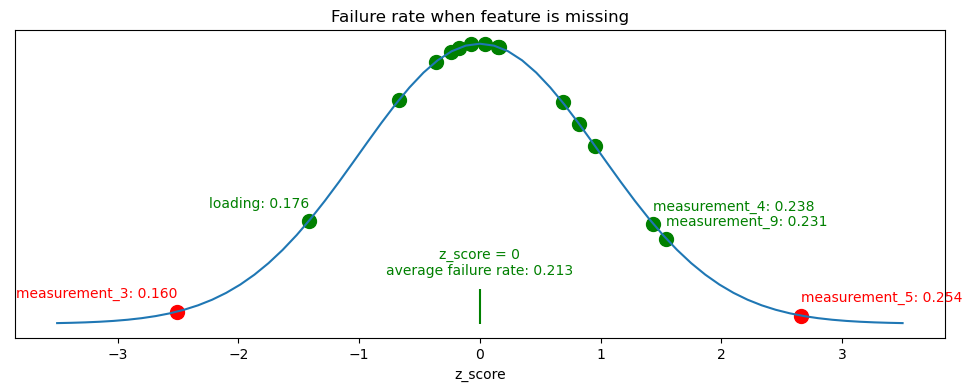

In [4]:
from scipy import stats

expected_value_for_fail_devided_by_total = (df.failure.value_counts() / len(df))[1]

plt.figure(figsize=(12, 4))
z_ticks = np.linspace(-3.5, 3.5, 61)
pdf = stats.norm.pdf(z_ticks)
plt.plot(z_ticks, pdf)

print('feature           fail   miss   failure rate       z    p-value')
for f in df.columns:
    if df[f].isna().sum() > 0:
        total = df[f].isna().sum()
        fail = df[df[f].isna()].failure.sum()
        z = (fail / total - expected_value_for_fail_devided_by_total) / (np.sqrt(expected_value_for_fail_devided_by_total * (1-expected_value_for_fail_devided_by_total)) / np.sqrt(total))
                                                                        # The standard deviation for fail/total is sqrt(n * p * (1-p))/n , 因為std(c*x) = std(x) * c
        plt.scatter([z], [stats.norm.pdf(z)], c='r' if abs(z) > 2 else 'g', s=100)
        print(f"{f:15} : {fail:4} / {total:4} = {fail/total:.3f}          {z:5.2f}      {2*stats.norm.cdf(-abs(z)):.3f}")
        if abs(z) > 1: plt.annotate(f"{f}: {fail / total:.3f}",
                                    (z, stats.norm.pdf(z)),
                                    xytext=(0,10), 
                                    textcoords='offset points', ha='left' if z > 0 else 'right',
                                    color='r' if abs(z) > 2 else 'g')
            
# Annotage the center (z=0)
plt.vlines([0], 0, 0.05, color='g')
plt.annotate(f"z_score = 0\naverage failure rate: {0.212608:.3f}",
                                    (0, 0.05),
                                    xytext=(0,10), 
                                    textcoords='offset points', ha='center',
                                    color='g')
plt.title('Failure rate when feature is missing')
plt.yticks([])
plt.xlabel('z_score')
plt.show()

利用.value_counts()查看categorical類型的各個columns分別有幾類 : 

product_code : 5類
attribute_0 : 2類
attribute_1 : 3類

此外 , 當我們查看numerical類型的columns時發現attribute_2 , attribute_3都只有4類value , 所以也可能是categorical的但是以數字表示。

In [5]:
categorical_columns = []
numerical_columns = []
potential_categorical_columns = []

numeric_columns = train_df.select_dtypes(exclude=['object']).columns
for name in numeric_columns:
    unique_vals = len(df[name].value_counts())
    if(unique_vals <= 10):
        print(name)
        potential_categorical_columns.append(name)
        print(df[name].value_counts())
    numerical_columns.append(name)
    
    
non_numeric_columns = train_df.select_dtypes(include=['object']).columns
for name in non_numeric_columns:
    print(name)
    categorical_columns.append(name)
    print(df[name].value_counts())

print(potential_categorical_columns)
print(categorical_columns)

attribute_2
6    10455
5     5765
8     5250
9     5100
Name: attribute_2, dtype: int64
attribute_3
8    11015
9     5343
6     5112
5     5100
Name: attribute_3, dtype: int64
product_code
C    5765
E    5343
B    5250
D    5112
A    5100
Name: product_code, dtype: int64
attribute_0
material_7    21320
material_5     5250
Name: attribute_0, dtype: int64
attribute_1
material_8    10865
material_5    10362
material_6     5343
Name: attribute_1, dtype: int64
['attribute_2', 'attribute_3']
['product_code', 'attribute_0', 'attribute_1']


看看各個column的NaN比例
可以看出來這份dataset有很多missing value , 因此可以推斷可以適當處理missing value的preprocess方式可以勝出

Text(0, 0.5, 'Column names')

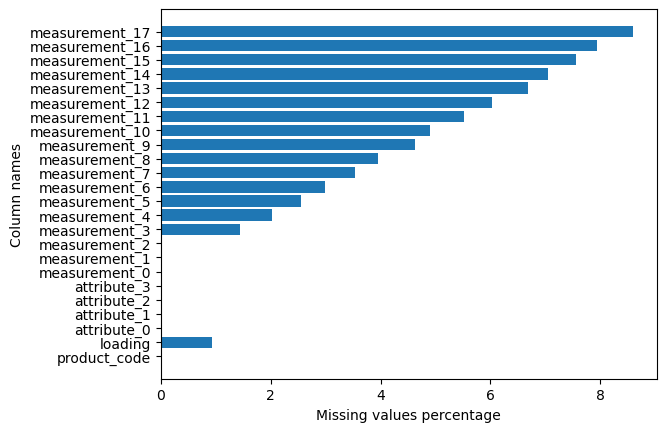

In [6]:
percent = []
for column in train_df.columns:
    percent.append(train_df[column].isna().sum()/len(train_df)*100)

plt.barh(y = train_df.columns, width = percent)
plt.xlabel("Missing values percentage")
plt.ylabel("Column names")

Print out the correlations among different features using heatmap

由下圖可以看到 , attribute2和attribute3有較高的負相關度(以統計學角度通常abs(corr) >= 0.7視為高度相關) , 我們可以嘗試把其中一個column剔除以避免problem of collinearity

/tmp/ipykernel_3798509/3739489690.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(seaborn.heatmap(train_df.corr() , annot = True))


AxesSubplot(0.125,0.11;0.62x0.77)


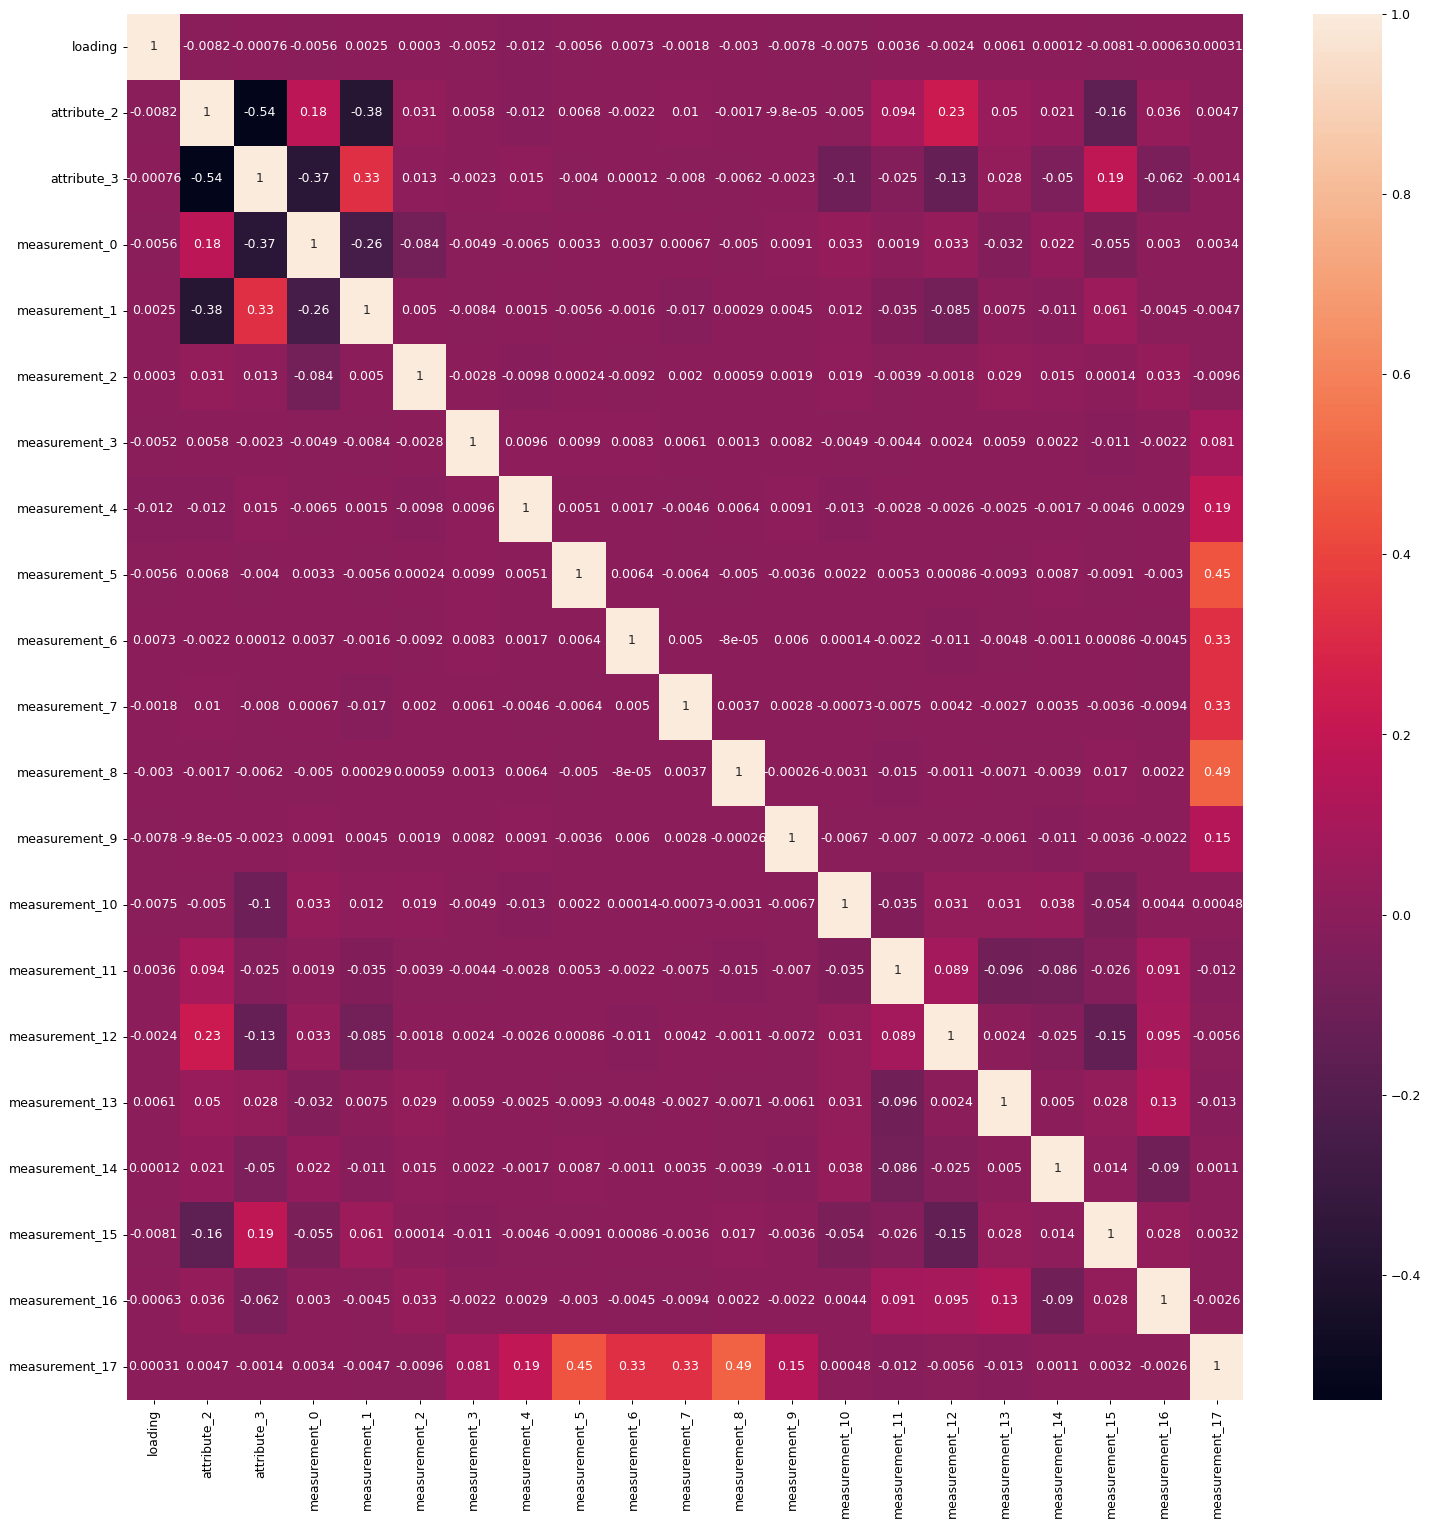

In [7]:
import seaborn
plt.figure(figsize=(20,20), dpi=90)
print(seaborn.heatmap(train_df.corr() , annot = True))

建構從data-preprocessing的pipeline + 預測

In [8]:
def data_preprocessing(new_df , numerical_col , categorical_col):
    nn = []
    cc = []
    for f in new_df.columns:
        if f in numerical_col:
            nn.append(f)
        else:
            cc.append(f)
    # print(nn)
    # print(cc)
    numerical_pipe = Pipeline([
        ('impute', SimpleImputer()),
        ('scale', MinMaxScaler()),
    ])
    categorical_pipe = Pipeline([
        ('encode', OrdinalEncoder())
    ])
    preprocessor = ColumnTransformer([
        ('numeric', numerical_pipe, nn),
        ('categorical', categorical_pipe, cc),
    ])    
    return preprocessor


def feature_engineering(df , num_col , cat_col , try_add_m3m5_missing , try_self_defined_columns , try_drop_attr2 , try_drop_attr3):
    df_modified = df.copy()
    if try_add_m3m5_missing == True:
        df_modified['m_3_missing'] = df_modified.measurement_3.isna()
        df_modified['m_5_missing'] = df_modified.measurement_5.isna()
        cat_col = cat_col + ["m_3_missing" , "m_5_missing"]
    if try_drop_attr2 == True :
        df_modified = df_modified.drop(["attribute_2"] , axis = 1)
        num_col = list(set(num_col) - set(["attribute_2"]))
    if try_drop_attr3 == True :
        df_modified = df_modified.drop(["attribute_3"] , axis = 1)
        num_col = list(set(num_col) - set(["attribute_3"]))
    if try_self_defined_columns == True and try_drop_attr2 == False and try_drop_attr3 == False:
        cat_col = cat_col + ["attribute_2" , "attribute_3"]
        num_col = list(set(num_col) - set(["attribute_2" , "attribute_3"])) 

    return df_modified , num_col , cat_col

Try 2 : NN
Best private score : SimpleImputer() + OrdinalEncoder() + all true without self-defined columns type --> 0.58833

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2023-01-04 23:07:36.832169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 23:07:36.839835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 23:07:36.882660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 23:07:36.882820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

In [10]:
b = 128
y = label_df.values
for try_add_m3m5_missing in [True]:
    for try_self_defined_columns in [False]:
        for try_drop_attr2 in [True]:
            for try_drop_attr3 in [True]:
                # Train
                new_train_df , num_col , cat_col = feature_engineering(train_df , numerical_columns ,
                categorical_columns , try_add_m3m5_missing , try_self_defined_columns , try_drop_attr2 , try_drop_attr3)
                preprocessor = data_preprocessing(new_train_df , num_col , cat_col)
                preprocessed_new_train = preprocessor.fit_transform(new_train_df)
                # print(np.argwhere(np.isnan(preprocessed_new_train)))
                model = keras.Sequential([
                    layers.Dense(32, input_shape=[preprocessed_new_train.shape[1]] , activation='swish'),
                    layers.Dropout(0.2),
                    layers.Dense(32, activation='swish'),
                    layers.Dropout(0.2),
                    layers.Dense(1, activation='sigmoid'),
                ])
                model.compile(
                    optimizer = tf.keras.optimizers.Adam(),
                    loss='binary_crossentropy',
                    metrics=[keras.metrics.AUC(name = 'auc')],
                )
                early_stopping = keras.callbacks.EarlyStopping(
                    patience=5,
                    min_delta=0.001,
                    restore_best_weights=True,
                )
                model.fit(
                    preprocessed_new_train, y,
                    batch_size = b ,
                    epochs=200,
                    callbacks=[early_stopping],
                    verbose = 0
                )
                model.save('train_NN.h5')

2023-01-04 23:07:37.439533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 23:07:37.439702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 23:07:37.439795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 23:07:37.440202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 23:07:37.440301: I tensorflow/compiler/xla/stream_executo